In [1]:
# Mateusz Biegański
# mb385162

# Data Mining 2020-2021 course, MIMUW

In [135]:
# Libraries used.

# Python-like fstrings.
library(glue);

# Misc utils.
library(dplyr);

# Plots.
library(ggplot2);

# B-splines for 'ggplot' smooth plots. 
library(splines);

# Reading .csv in efficient way.
library(data.table);

library(glmnet)

library(Rfast)


In [4]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))
id = function(x) x

In [599]:
TRAIN_DATA_FNAME = "training_data_tabular_format.csv"
TEST_DATA_FNAME = "test_data_tabular_format.csv"
DATA_LEN=10000


gen_model_matrix = function(fname, data_len=10000) {
    df <- fread(fname)
    print(dim(df))
    tmp <- which(colSums(is.na(df)) < dim(df)[[1]]/5) # remove columns with >20% of NAs
    df <- df[, ..tmp]
    print(dim(df))
    tmp <- (names(df) %in% c("players.0.ai", "players.1.ai", "id", "players.1.player_id", "players.0.player_id")) # those values are irrelevant
    df <- df[, -..tmp]
    print(dim(df))
#     df <- df[sample(nrow(df), data_len), ]
    y <- df %>% select("winner")
    y <- y %>% as.matrix %>% t
    t <- df[,"t"]
    df <- df %>% select(-"t")
    print(dim(df))
    
    invisible(gc())
    mm <- model.matrix(~.-winner, df)
    mm <- cbind(mm, t)

    print(dim(mm))
    
    # Pick only most variant variables.
    TOP_VAR_NUM = 300
    variances <- colVars(as.matrix(mm))
    variances <- cbind(colnames(mm) %>% data.frame, as.numeric(variances))
    variances.top <- variances[order(variances[,2], decreasing=TRUE) ,] %>% head(n=TOP_VAR_NUM)
    variances.top.names = variances.top[[1]]
    mm <- as.matrix(mm)
    mm <- mm[,which(colnames(mm) %in% variances.top.names)]
    
    mm <- as.matrix(mm)
    
    # TODO
    mm <- scale(mm)
    
    print(dim(mm))
    invisible(gc())
    list(mm, y)
}

Xy <- gen_model_matrix(TRAIN_DATA_FNAME, DATA_LEN)
mm <- Xy[[1]]
y  <- Xy[[2]]
head(mm, n=3)
head(y, n=3)

[1] 38658   198
[1] 38658   172
[1] 38658   167
[1] 38658   166
[1] 38658  1628
[1] 38658   300


version0.13.3,version0.9.2,map_nameMap03,map_nameMap04,map_nameMap05,map_nameMap07,map_nameMap08,map_nameMap10,map_nameMap11,map_nameMap12,⋯,teams.1.3.gadgets_stats.1.idbtrRam01,teams.1.3.gadgets_stats.1.idmed01,teams.1.3.gadgets_stats.1.idsprnt01,teams.1.3.gadgets_stats.1.idthrml01,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.idsprnt01,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.cnt,t
-0.4164202,1.102649,-0.2087311,-0.216441,4.6885802,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,-0.4550151,-0.5551316,-0.2719937,2.252134,-0.2719937,1.8556420,1.2603927,-0.2336948,0.4304238
-0.4164202,1.102649,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,2.1976726,-0.5551316,-0.2719937,1.015971,-0.2719937,-0.8845993,-0.5471552,-0.2336948,0.5669304
-0.4164202,1.102649,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,-0.4550151,-0.5551316,-0.2719937,-0.220193,-0.2719937,-0.8845993,-0.5471552,-0.2336948,0.4842836


winner,1,1,1,1,1,1,0,1,1,0,⋯,0,0,0,1,0,0,1,0,1,0


In [371]:
predict(mdcv)

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "xgb.cv.synchronous"


In [427]:
x <- prcomp(mm, center=T, scale=F)
summary(x)

In [505]:
mm_svd = svd(mm)

In [506]:
num_features = length(mm_svd$d)
concept_names = paste("concept", 1:num_features, sep="")
names(mm_svd$d) = concept_names

xx <- round(mm_svd$d, 3)
xx <- round(mm_svd$v, 3)
xx <- round(mm_svd$u, 3)

rownames(mm_svd$v) = colnames(mm)
colnames(mm_svd$v) = concept_names

rownames(mm_svd$u) = rownames(mm)
colnames(mm_svd$u) = concept_names

In [519]:
N_FEATURES = 50

D = diag(mm_svd$d[1:N_FEATURES])
V = mm_svd$v[,1:N_FEATURES]
U = mm_svd$u[,1:N_FEATURES]

# approxData = U %*% D %*% t(V)
conceptData = mm %*% V
round(conceptData, 3) %>% head(n=2)

concept1,concept2,concept3,concept4,concept5,concept6,concept7,concept8,concept9,concept10,⋯,concept41,concept42,concept43,concept44,concept45,concept46,concept47,concept48,concept49,concept50
-261.910,112.975,68.777,-38.605,5.370,57.425,-79.501,6.828,-12.410,-51.445,⋯,-17.172,1.337,-2.165,1.168,0.702,-0.379,-0.800,-0.653,1.560,0.803
-300.552,35.313,70.004,70.306,-15.374,16.645,43.178,-16.485,38.545,7.378,⋯,-3.588,2.061,0.552,1.832,-1.575,0.631,0.626,1.184,0.524,0.760


In [589]:
head(mm)

version0.13.3,version0.9.2,map_nameMap03,map_nameMap04,map_nameMap05,map_nameMap07,map_nameMap08,map_nameMap10,map_nameMap11,map_nameMap12,⋯,teams.1.3.gadgets_stats.1.idbtrRam01,teams.1.3.gadgets_stats.1.idmed01,teams.1.3.gadgets_stats.1.idsprnt01,teams.1.3.gadgets_stats.1.idthrml01,teams.1.3.gadgets_stats.1.cnt,teams.1.3.gadgets_stats.2.idsprnt01,teams.1.3.gadgets_stats.2.cnt,teams.1.3.gadgets_stats.3.cnt,teams.1.3.gadgets_stats.4.cnt,t
-0.4164202,1.1026489,-0.2087311,-0.216441,4.6885802,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,-0.4550151,-0.5551316,-0.2719937,2.252134,-0.2719937,1.8556420,1.2603927,-0.2336948,0.43042378
-0.4164202,1.1026489,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,2.1976726,-0.5551316,-0.2719937,1.015971,-0.2719937,-0.8845993,-0.5471552,-0.2336948,0.56693041
-0.4164202,1.1026489,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,-0.4550151,-0.5551316,-0.2719937,-0.220193,-0.2719937,-0.8845993,-0.5471552,-0.2336948,0.48428355
-0.4164202,-0.9068835,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,4.6172838,-0.4550151,-0.5551316,-0.2719937,2.252134,-0.2719937,1.8556420,1.2603927,-0.2336948,-0.26056843
-0.4164202,-0.9068835,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,2.1976726,-0.5551316,-0.2719937,1.015971,-0.2719937,0.4855213,-0.5471552,3.4253467,-0.07343736
-0.4164202,1.1026489,-0.2087311,-0.216441,-0.2132787,-0.2075135,-0.2159822,-0.20731,-0.2153911,-0.2127478,⋯,-0.2165719,2.1976726,-0.5551316,-0.2719937,1.015971,-0.2719937,0.4855213,-0.5471552,-0.2336948,-0.21651639


In [588]:
mdcv <- xgb.cv(
    params=list(
        objective="binary:logistic",
        eval_metric=list("auc"),
        min_child_weight=15,
        gamma=5
    ),
    data=mm, # conceptData, # mm
    eta=0.10,
    metric=list("auc"),
    label=y,
    nfold=5,
    nrounds=170,
    max_depth = 5,
    print_every_n = 10,
    showsd=F,
)
mdcv$test.error.mean

[1]	train-auc:0.749736	test-auc:0.735538 
[11]	train-auc:0.830086	test-auc:0.815160 
[21]	train-auc:0.843001	test-auc:0.825158 
[31]	train-auc:0.851406	test-auc:0.830984 
[41]	train-auc:0.858697	test-auc:0.834977 
[51]	train-auc:0.864601	test-auc:0.837806 
[61]	train-auc:0.870265	test-auc:0.840111 
[71]	train-auc:0.875768	test-auc:0.842259 
[81]	train-auc:0.880456	test-auc:0.843741 
[91]	train-auc:0.884950	test-auc:0.844977 
[101]	train-auc:0.888857	test-auc:0.846209 
[111]	train-auc:0.892431	test-auc:0.847158 
[121]	train-auc:0.895704	test-auc:0.847997 
[131]	train-auc:0.898893	test-auc:0.848634 
[141]	train-auc:0.901825	test-auc:0.849039 
[151]	train-auc:0.904560	test-auc:0.849461 
[161]	train-auc:0.907298	test-auc:0.849698 
[170]	train-auc:0.909416	test-auc:0.849935 


NULL

In [607]:
dim(mm)
dim(cleaned_test_mm)

result <- predict(xgb, newdata=cleaned_test_mm) %>% data.frame

store(result, fname="xgboost_full_md5_mcw15_g5.txt")



[1] 38658   300

[1] 20000   300

In [598]:
mm %>% dim

[1] 20000   300

In [606]:
library(xgboost)

xgb <- xgboost(
    data=mm,
    label=y,
    objective="binary:logistic",
    eval_metric="auc",
    print_every_n = 5,
    
    nrounds=500, 
    
    max_depth=5, 
    min_child_weight=15,
    eta = 0.1,
    gamma=5,
)

m(xgb)


[1]	train-auc:0.749517 
[6]	train-auc:0.817074 
[11]	train-auc:0.828491 
[16]	train-auc:0.835645 
[21]	train-auc:0.840645 
[26]	train-auc:0.844528 
[31]	train-auc:0.848667 
[36]	train-auc:0.852161 
[41]	train-auc:0.855269 
[46]	train-auc:0.857962 
[51]	train-auc:0.860827 
[56]	train-auc:0.863564 
[61]	train-auc:0.866873 
[66]	train-auc:0.869464 
[71]	train-auc:0.871710 
[76]	train-auc:0.874030 
[81]	train-auc:0.876337 
[86]	train-auc:0.878349 
[91]	train-auc:0.880464 
[96]	train-auc:0.882342 
[101]	train-auc:0.884023 
[106]	train-auc:0.885577 
[111]	train-auc:0.887593 
[116]	train-auc:0.888951 
[121]	train-auc:0.890454 
[126]	train-auc:0.891901 
[131]	train-auc:0.892861 
[136]	train-auc:0.894573 
[141]	train-auc:0.895765 
[146]	train-auc:0.897053 
[151]	train-auc:0.898195 
[156]	train-auc:0.899287 
[161]	train-auc:0.900474 
[166]	train-auc:0.901557 
[171]	train-auc:0.902990 
[176]	train-auc:0.904199 
[181]	train-auc:0.905139 
[186]	train-auc:0.906234 
[191]	train-auc:0.907157 
[196]	tr


Call:  cv.glmnet(x = mm, y = y, type.measure = "class", parallel = TRUE,      family = "binomial", alpha = alpha) 

Measure: Misclassification Error 

    Lambda Index Measure       SE Nonzero
min 0.3664    63  0.2607 0.007384     300
1se 0.6403    57  0.2653 0.007170     300

Call:  cv.glmnet(x = mm, y = y, type.measure = "class", parallel = TRUE,      family = "binomial", alpha = alpha) 

Measure: Misclassification Error 

     Lambda Index Measure       SE Nonzero
min 0.02514    25  0.2447 0.009192      57
1se 0.05292    17  0.2533 0.010864      17

Call:  cv.glmnet(x = mm, y = y, type.measure = "class", parallel = TRUE,      family = "binomial", alpha = alpha) 

Measure: Misclassification Error 

     Lambda Index Measure      SE Nonzero
min 0.01444    29  0.2497 0.01308      94
1se 0.08458    10  0.2593 0.01060      16

Call:  cv.glmnet(x = mm, y = y, type.measure = "class", parallel = TRUE,      family = "binomial", alpha = alpha) 

Measure: Misclassification Error 

     Lambda

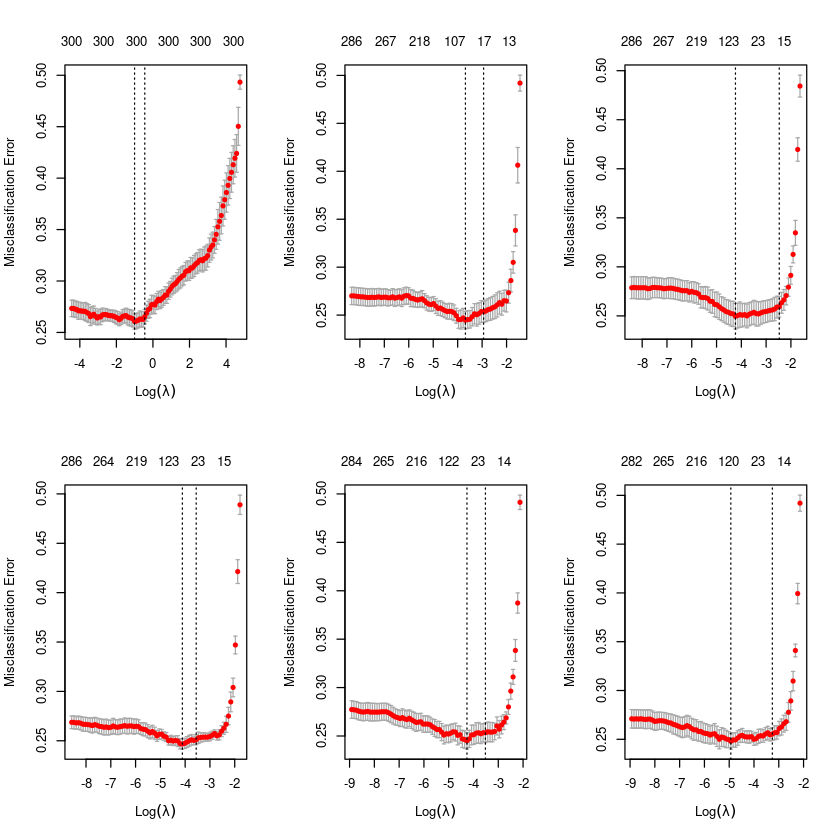

In [323]:
library(doParallel)
registerDoParallel(4)

elastic_fn = function(alpha) {
    cvfit <- cv.glmnet(mm, y, family="binomial", type.measure="class", alpha=alpha, parallel=TRUE)
    plot(cvfit)
    print(cvfit)
    cvfit
}

library("purrr")
tuning_alpha = c(0.0, .5, .6, .7, .98, 1.0)

par(mfrow=c(2,3))
cvfits <- map(tuning_alpha, elastic_fn)

# cvfit <- cv.glmnet(mm, y, family = "binomial", type.measure = "class", alpha=1, parallel=TRUE)
# print(cvfit)
# plot(cvfit)

[[1]]
[1] 0.006831301

[[2]]
[1] 0.008317763

[[3]]
[1] 0.01116708

[[4]]
[1] 0.009801109

[[5]]
[1] 0.007456872

[[6]]
[1] 0.00825818

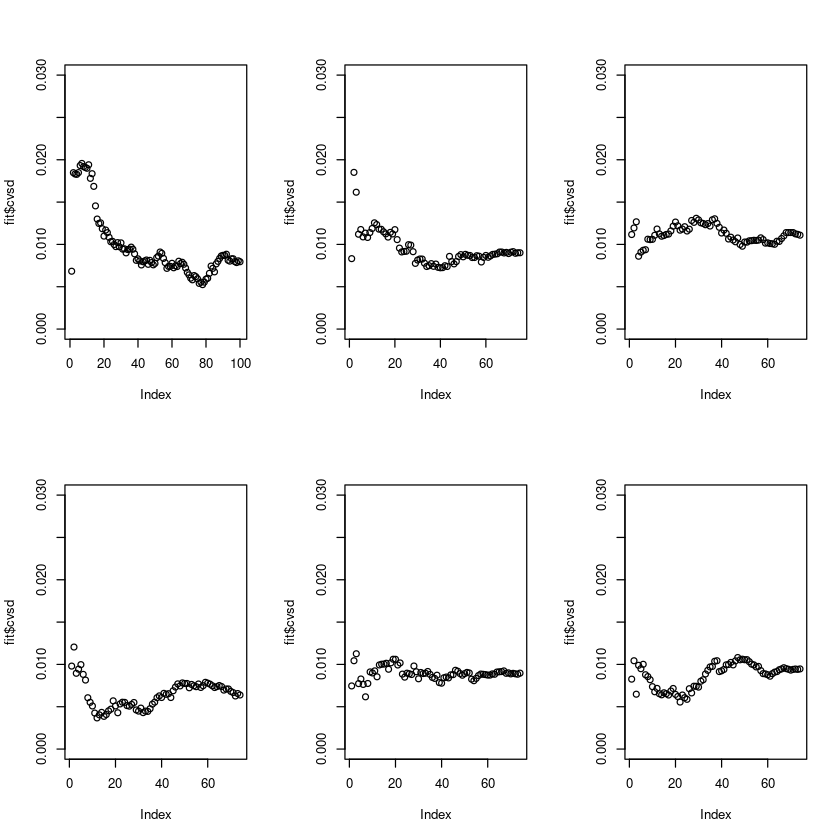

In [324]:
indices_1se <- map(cvfits, function(fit) {fit$cvsd[fit$index["1se",]]} ) 
par(mfrow=c(2,3))
map2(cvfits, indices_1se, function(fit, idx) {plot(fit$cvsd, ylim=c(0, 0.03)) }) %>% invisible
cvms <- map2(cvfits, indices_1se, function(fit, idx) { fit$cvsd[[idx]] })
cvms

In [600]:
gen_test_model_matrix = function(fname, train_mm, data_len=10000) {
    df <- fread(fname)
    dim(df)
    
    tmp <- which(colSums(is.na(df)) < 1) # remove columns with >20% of NAs   dim(df)[[1]]/5
    df <- df[, ..tmp]
    dim(df)
    
    tmp <- (names(df) %in% c("players.0.ai", "players.1.ai", "id", "players.1.player_id", "players.0.player_id")) # those values are irrelevant
    df <- df[, -..tmp]
    dim(df)
#     df <- df[sample(nrow(df), data_len), ]
    t <- df[,"t"]
    df <- df %>% select(-"t")
    dim(df)
    
    mm <- model.matrix(~., df)
    mm <- cbind(mm, t)
    mm <- as.matrix(mm)
    invisible(gc())
    mm
}


test_mm <- gen_test_model_matrix(TEST_DATA_FNAME, mm, 20000)


head(test_mm)

# cvfit %>% predict(as.matrix(test_mm), type="response")

(Intercept),version0.12.0,version0.12.1,version0.13.3,version0.9.2,version1.0.0,map_nameMap02,map_nameMap03,map_nameMap04,map_nameMap05,⋯,teams.1.3.gadgets_stats.4.idshd05,teams.1.3.gadgets_stats.4.idshd06,teams.1.3.gadgets_stats.4.idsprnt01,teams.1.3.gadgets_stats.4.idstm01,teams.1.3.gadgets_stats.4.idstm02,teams.1.3.gadgets_stats.4.idstm03,teams.1.3.gadgets_stats.4.idstm04,teams.1.3.gadgets_stats.4.idstm05,teams.1.3.gadgets_stats.4.cnt,t
1,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,80.00335
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,243.32095
1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,84.58365
1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,76.41979
1,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,152.01454
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,122.96463


In [601]:
test_mm %>% dim
mm %>% dim

cleaned_test_mm <- test_mm[,which(colnames(test_mm) %in% colnames(mm))]
cleaned_test_mm %>% dim

[1] 20000  1633

[1] 38658   300

[1] 20000   300

In [602]:
setdiff(colnames(mm), colnames(cleaned_test_mm))

dummy_indices <- which(colnames(mm) %in% setdiff(colnames(mm), colnames(cleaned_test_mm)))
dummy_indices

for (idx in dummy_indices) {
    cname = colnames(mm)[[idx]] # paste("dummy", idx, sep="")
    total_cols = ncol(cleaned_test_mm)
    total_rows = nrow(cleaned_test_mm)
#     dummy_col = data.frame(0, nrow=20000)
#     head(dummy_col) %>% print
    cleaned_test_mm <- cbind(cleaned_test_mm[,1:(idx-1)], 0, cleaned_test_mm[,idx:ncol(cleaned_test_mm)])
    colnames(cleaned_test_mm)[idx] <- cname
    dummy_id = dummy_id + 1
}


cleaned_test_mm <- scale(cleaned_test_mm, center=attr(mm, "scaled:center"), scale=attr(mm, "scaled:scale"))

dim(cleaned_test_mm)

character(0)

integer(0)

[1] 20000   300

In [377]:
mm %>% dim
cleaned_test_mm %>% dim

colnames(cleaned_test_mm)[1608]
colnames(mm)[1608]

[1] 38658   200

[1] 20000   200

[1] NA

[1] NA

In [329]:
result <- predict(cvfits[[4]], newx=cleaned_test_mm, s='lambda.min', type="response") 
result %>% head

store = function(result, fname) {
    write.table(result, file=fname, sep="", row.names=FALSE, col.names=FALSE)
}
store(result, fname="glmnet_3k_var_300.txt")

1
0.4282154
0.4887874
0.2695679
0.4842705
0.4897907
0.6157563


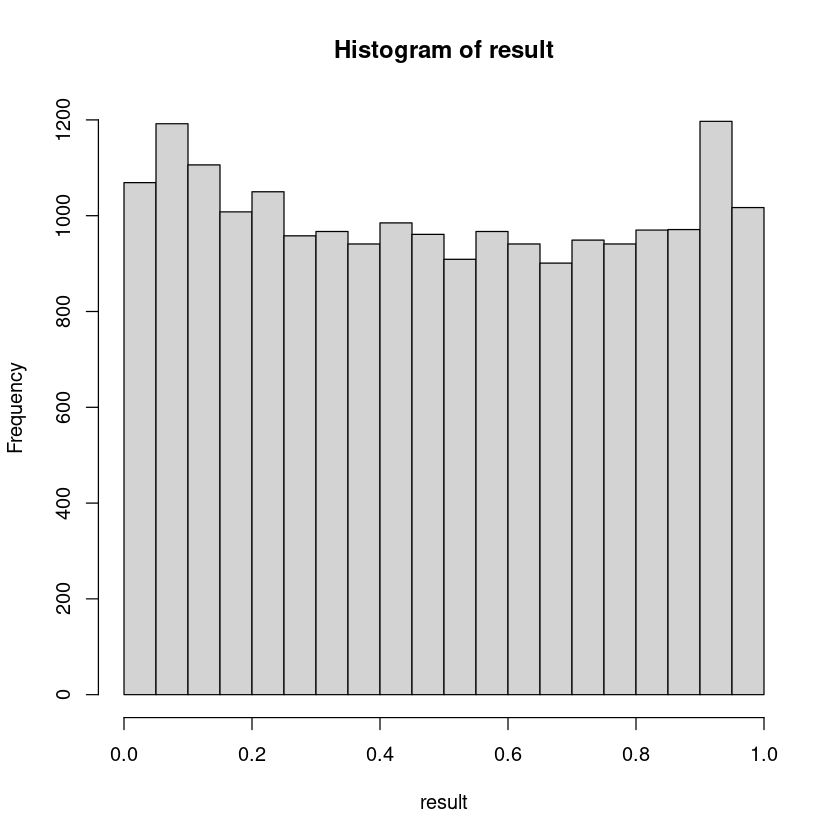

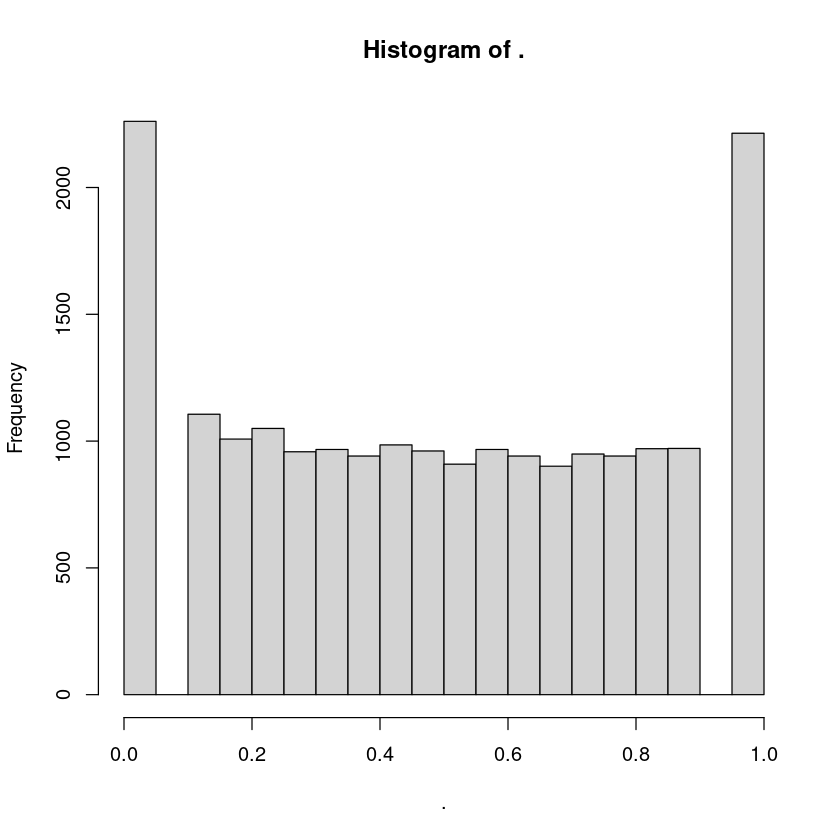

In [130]:
hist(result)

postprocess = function(result) {
    th_plus = 0.90
    th_minus = 1 - th_plus
    sapply(result, function(x) {if (x > th_plus) {1} else if (x < th_minus) {0} else {x}})
}

result %>% postprocess %>% hist
result %>% postprocess %>% store(fname="glmnet_full_th90.txt")

In [126]:
# cvfit %>% predict(as.matrix(test_mm), type="response")
# dim(test_mm)
# dim(mm)

test_mm <- test_mm[,which(colnames(test_mm) %in% colnames(mm))]
dim(test_mm)
dim(mm)
# test_mm[,"winner"]
# mm[,"winner"]
# cvfit %>% predict(as.matrix(test_mm), type="response")

# mm[,-which(colnames(mm) %in% colnames(test_mm))]
setdiff(1:1579, which(colnames(mm) %in% colnames(test_mm)))
colnames(mm)[1560]

[1] 20000  1578

[1] 3000 1579

[1] 1560

[1] "teams.1.3.gadgets_stats.4.idmin01"